# Library

In [1]:
from skimage.io import imread_collection
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from skimage.transform import resize

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,accuracy_score
from scipy.stats import randint as sp_randint

from matplotlib import pyplot as plt
import numpy as np
import time

# Data

In [2]:
Glaucoma = imread_collection("../../../Documents/Bases/RIMONE_v2/Training/Glaucoma/*.jpg")
Normal = imread_collection("../../../Documents/Bases/RIMONE_v2/Training/Normal/*.jpg")

# Parameter Local Binary Pattern

In [3]:
radius = 3
n_points = 8 * radius
METHOD = 'uniform'

#  Local Binary Pattern

In [4]:
def lbp(image):
    
    props = np.zeros((50176))
    
    lbp = local_binary_pattern(
        rgb2gray(image),
        n_points,
        radius, METHOD
    )
    
    for id_,pix in enumerate(lbp.ravel()):
        props[id_] = pix

    return props

In [5]:
labels = np.concatenate((np.ones(len(Glaucoma)),np.zeros(len(Normal))))
features = np.zeros((len(labels),50176))

for id_img,img in enumerate(Glaucoma):
    features[id_img] = lbp(resize(img, (224,224)))
    
for id_img,img in enumerate(Normal):
    features[id_img+len(Glaucoma)] = lbp(resize(img, (224,224)))

In [6]:
train = 0.9
test = 1-train

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test)

# Random Forest Parameter

In [8]:
def rf_parameter_estimation(xEst, yEst):
    
    clf = RandomForestClassifier(n_estimators=20)    
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10,1000,50),
                  "max_depth": range(1,100),
                  "max_features": sp_randint(1, xEst.shape[1]),
                  "min_samples_split": sp_randint(2, xEst.shape[1]),
                  "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
    
    
    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search,scoring=make_scorer(accuracy_score))
    
    
    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

# Principal Component Analysis

In [9]:
def pca(X_train, X_test,y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train,y_train)
    transform = pca.transform(X_test)
    return transform

In [10]:
components = [50,100,200,300]

In [11]:
results_rf = np.zeros(len(components)+1)

start = time.time()
for id_comp,comp in enumerate(components):
    
    print('-------------','n comp. = ',comp,'-------------')
    
    X_train_pca = pca(X_train,X_train,y_train,comp)
    
    X_test_pca = pca(X_train,X_test,y_train,comp)
    
    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca,y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc

parameters = rf_parameter_estimation(X_train_pca, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train_pca,y_train)
pred = c_rf.predict(X_test_pca)
acc = accuracy_score(y_test, pred)
results_rf[len(components)] = acc
    
end = time.time()
print(end - start)

------------- n comp. =  50 -------------


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.836 (std: 0.023)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 93, 'max_features': 32, 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 310}
Model with rank: 1
Mean validation score: 0.836 (std: 0.028)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 55, 'max_features': 26, 'min_samples_leaf': 24, 'min_samples_split': 24, 'n_estimators': 210}
Model with rank: 1
Mean validation score: 0.836 (std: 0.023)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 60, 'max_features': 14, 'min_samples_leaf': 10, 'min_samples_split': 33, 'n_estimators': 960}
------------- n comp. =  100 -------------


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.830 (std: 0.029)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 56, 'max_features': 51, 'min_samples_leaf': 36, 'min_samples_split': 25, 'n_estimators': 560}
Model with rank: 2
Mean validation score: 0.826 (std: 0.035)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 21, 'max_features': 78, 'min_samples_leaf': 7, 'min_samples_split': 38, 'n_estimators': 810}
Model with rank: 3
Mean validation score: 0.823 (std: 0.027)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 44, 'max_features': 61, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 710}
Model with rank: 3
Mean validation score: 0.823 (std: 0.029)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 52, 'max_features': 66, 'min_samples_leaf': 31, 'min_samples_split': 99, 'n_estimators': 360}
------------- n comp. =  200 -------------


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.826 (std: 0.024)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 23, 'max_features': 156, 'min_samples_leaf': 56, 'min_samples_split': 33, 'n_estimators': 910}
Model with rank: 2
Mean validation score: 0.801 (std: 0.028)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 62, 'max_features': 85, 'min_samples_leaf': 54, 'min_samples_split': 93, 'n_estimators': 310}
Model with rank: 2
Mean validation score: 0.801 (std: 0.032)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 96, 'max_features': 125, 'min_samples_leaf': 60, 'min_samples_split': 53, 'n_estimators': 960}
------------- n comp. =  300 -------------


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.781 (std: 0.077)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 42, 'max_features': 261, 'min_samples_leaf': 30, 'min_samples_split': 98, 'n_estimators': 210}
Model with rank: 2
Mean validation score: 0.698 (std: 0.028)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 82, 'max_features': 135, 'min_samples_leaf': 88, 'min_samples_split': 131, 'n_estimators': 210}
Model with rank: 3
Mean validation score: 0.643 (std: 0.054)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 59, 'max_features': 222, 'min_samples_leaf': 65, 'min_samples_split': 119, 'n_estimators': 460}


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.733 (std: 0.056)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 171, 'min_samples_leaf': 45, 'min_samples_split': 110, 'n_estimators': 960}
Model with rank: 2
Mean validation score: 0.556 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'max_features': 118, 'min_samples_leaf': 272, 'min_samples_split': 178, 'n_estimators': 360}
Model with rank: 2
Mean validation score: 0.556 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 34, 'max_features': 122, 'min_samples_leaf': 43, 'min_samples_split': 171, 'n_estimators': 560}
Model with rank: 2
Mean validation score: 0.556 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 21, 'max_features': 138, 'min_samples_leaf': 183, 'min_samples_split': 118, 'n_estimators': 910}
Model with rank: 2
Mean validation score: 0.556 (std: 0.002)
Parameters: {'bootstrap': True, 'c

# Results

Text(0.5, 1.0, 'Helmets')

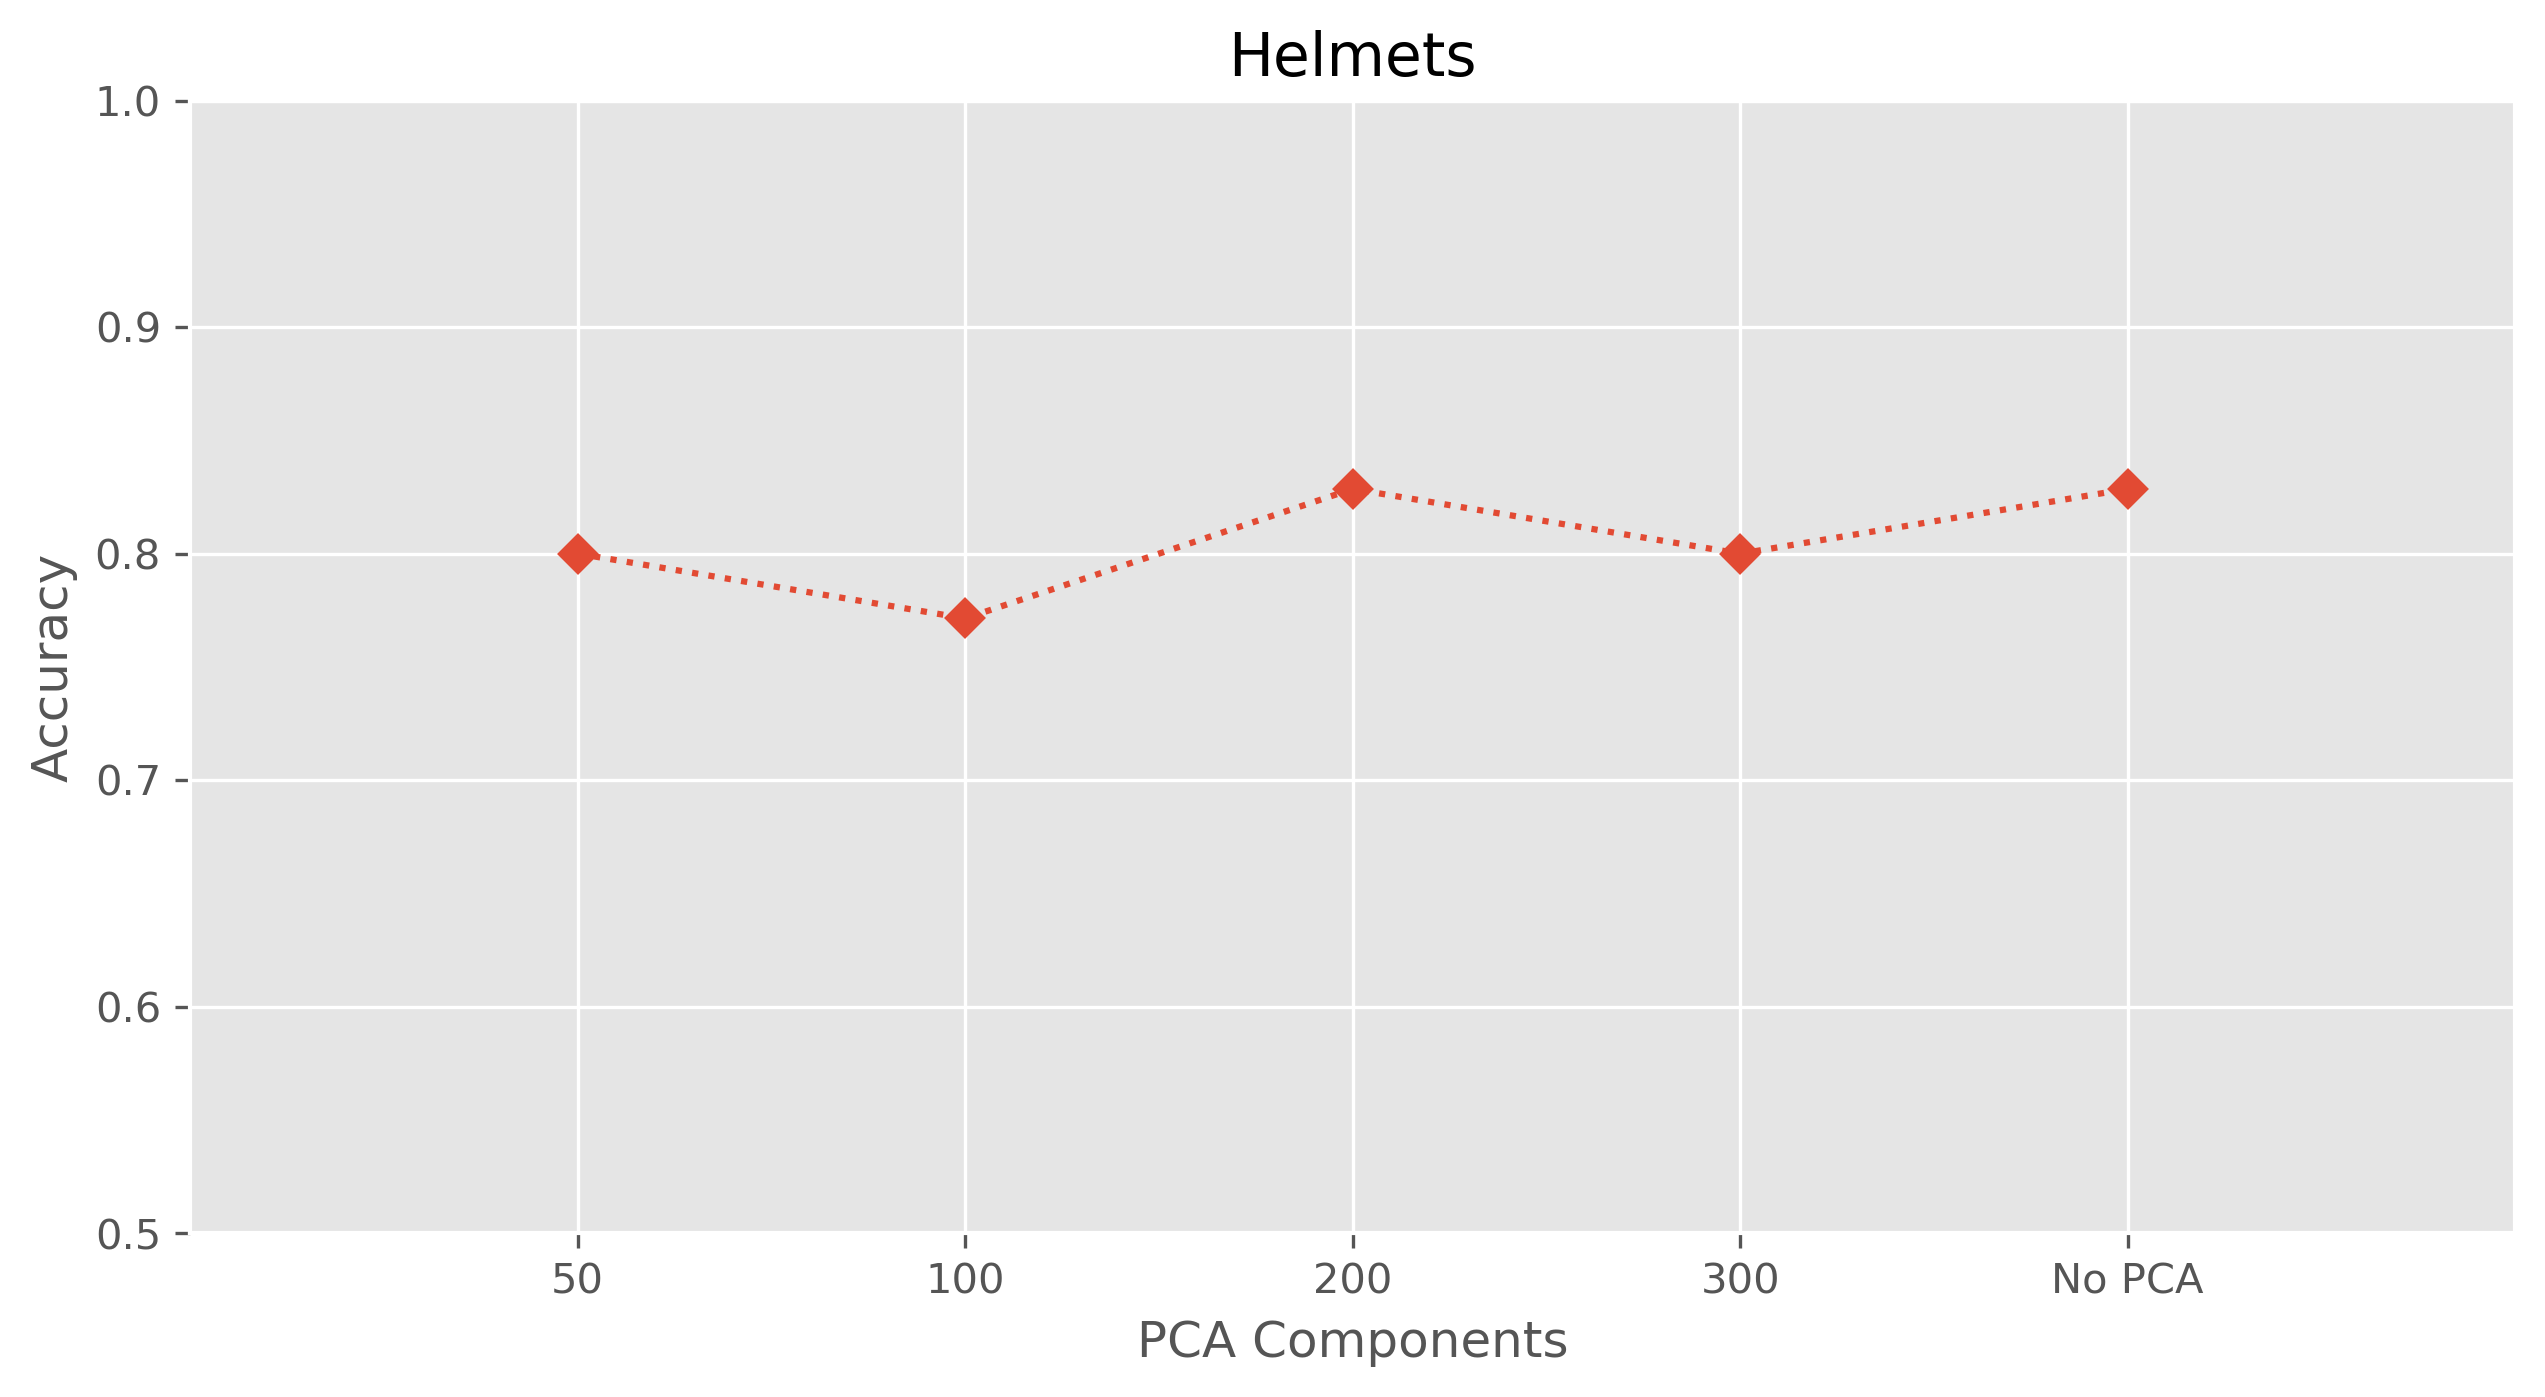

In [12]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (10,5),dpi=300)
ax = plt.subplot(111)
ax.plot(range(1,6),results_rf,marker = 'D',linestyle = ':',label = 'Random Forest')
ax.set_xlim([0,6])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1,6))
ax.set_xticklabels(['50','100','200','300','No PCA'])
ax.set_ylim([0.5,1])
ax.set_title('Helmets')

In [13]:
print("Best Acc: {} \nMethos: {} ".format(results_rf.max(),components[results_rf.argmax()]))

Best Acc: 0.8285714285714286 
Methos: 200 
